In [1]:
import os
os.chdir("../../../../")

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = str(0)

In [3]:
import jax
import jax.numpy as jnp
import numpy as np
import flax.linen as nn
import optax
import pandas as pd
from functools import partial
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from utilities.fits import fit
from data_small.dataset_loader import dataset_load
from utilities import plot, gmm, errors, predict, preprocess
from utilities.recalibration_conformal import *
from models import seq2point
import scipy.stats as st
# from mapie.metrics import regression_coverage_score
from sklearn.isotonic import IsotonicRegression
from tueplots import bundles
os.environ["XLA_FLAGS"] = "--xla_gpu_deterministic_reductions --xla_gpu_autotune_level=2"
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

2024-05-29 01:42:46.632389: W external/xla/xla/service/gpu/nvptx_compiler.cc:679] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


# Model Training

In [4]:
train = {1: {'start_time': "2014-06-20",'end_time': "2014-06-25"},
         2: {'start_time': "2014-06-20",'end_time': "2014-06-25"},
        #  4: {'start_time': "2014-06-20",'end_time': "2014-06-25"},
         5: {'start_time': "2014-06-20",'end_time': "2014-06-25"},
        #  6: {'start_time': "2014-06-20",'end_time': "2014-06-30"},
        #  7: {'start_time': "2014-06-15",'end_time': "2014-06-30"},
        #  9: {'start_time': "2014-06-15",'end_time': "2014-06-30"},
        #  10: {'start_time': "2014-06-15",'end_time': "2014-06-30"},
        #  11: {'start_time': "2014-06-15",'end_time': "2014-06-30"},
        #  13: {'start_time': "2014-06-15",'end_time': "2014-06-30"}
        }
test = {14: {'start_time': "2014-08-01",'end_time': "2014-08-10"},
        # 15: {'start_time': "2014-08-01",'end_time': "2014-08-10"},
        # 17: {'start_time': "2014-08-01",'end_time': "2014-08-10"},
        # 19: {'start_time': "2014-08-01",'end_time': "2014-08-10"},
        # 20: {'start_time': "2014-08-01",'end_time': "2014-08-10"}
       }
appliances = ["washing machine"]

In [5]:
datas = dataset_load(appliances, train, test, 99, split_factor=0.25)
x_train, y_train = datas[0], datas[1]
x_cal, y_cal = datas[2], datas[3]
x_test, y_test = datas[4], datas[5]
x_test_timestamp = datas[6]
scaler_x, scaler_y = datas[7], datas[8]

In [6]:
model = seq2point.seq2point()

In [7]:
params =  model.init(jax.random.PRNGKey(0), x_train, True)
params, losses = fit(model, params, x_train, y_train, False, batch_size=32, learning_rate=0.001, epochs=50)

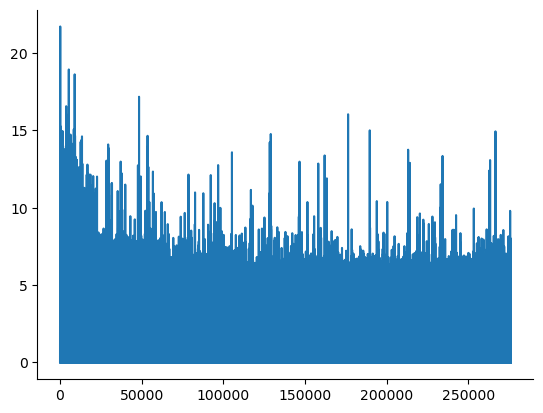

In [8]:
plt.plot(losses)
sns.despine()

In [15]:
n_stacks = 4


def fn(x, i): return model.apply(params, x, False,
                                 rngs={"dropout": jax.random.PRNGKey(i)})

# Before Calibration

##### Results on Calibration Set

In [16]:
y_stacks_cal = jax.vmap(jax.jit(fn), in_axes=(None, 0))(
    x_cal, jnp.arange(n_stacks))

In [17]:
mc_cal_mean = y_stacks_cal.mean(axis=0)
mc_cal_sigma = y_stacks_cal.std(axis=0)

In [18]:
mc_cal_mean = scaler_y.inverse_transform(mc_cal_mean)
mc_cal_sigma = (scaler_y.scale_*mc_cal_sigma)
y_true_cal = scaler_y.inverse_transform(y_cal)

In [19]:
print(f"RMSE : {errors.rmse(y_true_cal, mc_cal_mean):.4f} MAE  : {errors.mae(y_true_cal, mc_cal_mean):.4f} NLL : {errors.NLL(mc_cal_mean,mc_cal_sigma,y_true_cal):.4f}")

RMSE : 69.6759 MAE  : 10.0503 NLL : nan


##### Results on Training Set

In [20]:
y_stacks_train = jax.vmap(jax.jit(fn), in_axes=(None, 0))(
    x_train, jnp.arange(n_stacks))

In [21]:
mc_train_mean = y_stacks_train.mean(axis=0)
mc_train_sigma = y_stacks_train.std(axis=0)

In [22]:
mc_train_mean = scaler_y.inverse_transform(mc_train_mean)
mc_train_sigma = (scaler_y.scale_*mc_train_sigma)
y_train_scaled = scaler_y.inverse_transform(y_train)

In [23]:
print(f"RMSE : {errors.rmse(y_train_scaled, mc_train_mean):.4f}", f"MAE  : {errors.mae(y_train_scaled, mc_train_mean):.4f}",
      f"NLL  : {errors.NLL(mc_train_mean, mc_train_sigma, y_train_scaled):.4f}")

RMSE : 59.4461 MAE  : 9.1233 NLL  : nan


##### Results on Test Set

In [24]:
y_stacks_test = jax.vmap(jax.jit(fn), in_axes=(
    None, 0))(x_test, jnp.arange(n_stacks))

2024-05-29 01:59:58.019229: E external/xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng26{k2=0,k13=2,k14=3,k18=0,k22=0,k23=0} for conv (f32[408824,50,99]{2,1,0}, u8[0]{0}) custom-call(f32[408824,50,99]{2,1,0}, f32[50,50,5]{2,1,0}, f32[50]{0}), window={size=5 pad=2_2}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-05-29 01:59:58.145289: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.12620335s
Trying algorithm eng26{k2=0,k13=2,k14=3,k18=0,k22=0,k23=0} for conv (f32[408824,50,99]{2,1,0}, u8[0]{0}) custom-call(f32[408824,50,99]{2,1,0}, f32[50,50,5]{2,1,0}, f32[50]{0}), window={size=5 pad=2_2}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is 

In [25]:
mc_test_mean = y_stacks_test.mean(axis=0)
mc_test_sigma = y_stacks_test.std(axis=0)

In [26]:
mc_test_mean = scaler_y.inverse_transform(mc_test_mean)
mc_test_sigma = (scaler_y.scale_*mc_test_sigma)

In [27]:
print(f"RMSE : {errors.rmse(y_test, mc_test_mean):.4f}", f"MAE  : {errors.mae(y_test, mc_test_mean):.4f}",
      f"NLL  : {errors.NLL(mc_test_mean, mc_test_sigma, y_test):.4f}")

RMSE : 52.3403 MAE  : 4.5023 NLL  : nan


# After Calibration

### Isotonic Regression

In [28]:
def ace(ideal, predicted):
    """
    dataframe : pandas dataframe with Ideal and Counts as column for regression calibration
    It can be directly used as 2nd output from calibration_regression in plot.py 
    """
    def rmse_loss(y, yhat):
        return jnp.abs(y-yhat)
    return jnp.mean(jax.vmap(rmse_loss, in_axes=(0, 0))(ideal, predicted))

In [29]:
series_train = find_p_hat(y_train_scaled, mc_train_mean, mc_train_sigma)
series_test = find_p_hat(y_test, mc_test_mean, mc_test_sigma)
series_cal = find_p_hat(y_true_cal, mc_cal_mean, mc_cal_sigma)

In [30]:
calibrator = IsotonicRegression(out_of_bounds='clip')
calibrator.fit(series_cal.values, series_cal.index)

IsotonicRegression(out_of_bounds='clip')

In [31]:
p = series_cal.index
new_p = calibrator.predict(series_cal.index)

In [32]:
new_p_hat_train = find_new_p_hat(
    y_train_scaled, new_p, mc_train_mean, mc_train_sigma)
new_p_hat_cal = find_new_p_hat(y_true_cal, new_p, mc_cal_mean, mc_cal_sigma)
new_p_hat_test = find_new_p_hat(y_test, new_p, mc_test_mean, mc_test_sigma)

In [33]:
bundles.icml2022()

{'text.usetex': True,
 'font.family': 'serif',
 'text.latex.preamble': '\\usepackage{times} ',
 'figure.figsize': (3.25, 2.0086104634371584),
 'figure.constrained_layout.use': True,
 'figure.autolayout': False,
 'savefig.bbox': 'tight',
 'savefig.pad_inches': 0.015,
 'font.size': 8,
 'axes.labelsize': 8,
 'legend.fontsize': 6,
 'xtick.labelsize': 6,
 'ytick.labelsize': 6,
 'axes.titlesize': 8}

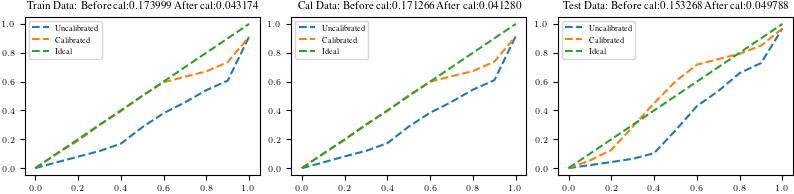

In [34]:
plt.rcParams.update(bundles.icml2022())
plt.rcParams.update({'figure.figsize': (8, 2)})
plt.subplot(1, 3, 1)
plt.plot(p, series_train.values, label='Uncalibrated', linestyle='--')
plt.plot(p, new_p_hat_train, label='Calibrated', linestyle='--')
plt.plot([0, 1], [0, 1], label="Ideal", linestyle='--')
plt.title(
    f"Train Data: Before cal:{ace(p.values,series_train.values):2f} After cal:{ace(p.values,new_p_hat_train):2f}")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(p, series_cal.values, label='Uncalibrated', linestyle='--')
plt.plot(p, new_p_hat_cal, label='Calibrated', linestyle='--')
plt.plot([0, 1], [0, 1], label="Ideal", linestyle='--')
plt.title(
    f"Cal Data: Before cal:{ace(p.values,series_cal.values):2f} After cal:{ace(p.values,new_p_hat_cal):2f}")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(p, series_test.values, label='Uncalibrated', linestyle='--')
plt.plot(p, new_p_hat_test, label='Calibrated', linestyle='--')
plt.plot([0, 1], [0, 1], label="Ideal", linestyle='--')
plt.title(
    f"Test Data: Before cal:{ace(p.values,series_test.values):2f} After cal:{ace(p.values,new_p_hat_test):2f}")
plt.legend()
# plt.savefig(
#     f'/home/haikoo.khandor/haikoo/conformal/con_figures/{appliances[0]}_S2P_Homo_MC.pdf')